In [2]:
!wget --no-check-certificate \
    https://github.com/omidmno2/stockMarketPrediction_DL/raw/main/tse_en.csv \
    -o /tmp/tse_en.csv

In [92]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import StandardScaler

In [145]:
df = pd.read_csv("tse_en.csv")
df[df.Symbol == "ولساپا"]

,Date,Symbol,Name,Yesterday,Open,Last,Close,Close Changes,Low,High,Number Traded,Volume,Value Traded
75,2008-12-06,ولساپا,ليزينگ رايان‌ سايپا,2490,2416,2416,2439,-51,2416.0,2416.0,66,164590,397649440
105,2008-12-07,ولساپا,ليزينگ رايان‌ سايپا,2439,2441,2441,2440,1,2441.0,2441.0,47,118990,290454590
208,2008-12-08,ولساپا,ليزينگ رايان‌ سايپا,2440,2442,2443,2441,1,2442.0,2443.0,41,92913,226896546
304,2008-12-10,ولساپا,ليزينگ رايان‌ سايپا,2441,2443,2443,2442,1,2443.0,2443.0,29,83000,202769000
400,2008-12-13,ولساپا,ليزينگ رايان‌ سايپا,2442,2444,2444,2443,1,2444.0,2444.0,33,73387,179357828
...,...,...,...,...,...,...,...,...,...,...,...,...,...
817403,2021-06-22,ولساپا,ليزينگ رايان‌ سايپا,2765,2800,2781,2774,9,2731.0,2870.0,1921,39328464,109092185313
817789,2021-06-23,ولساپا,ليزينگ رايان‌ سايپا,2774,2789,2800,2809,35,2715.0,2900.0,1634,41723750,117193496811
818103,2021-06-26,ولساپا,ليزينگ رايان‌ سايپا,2809,2830,2925,2928,119,2800.0,2949.0,2282,70567257,206615169408
818550,2021-06-27,ولساپا,ليزينگ رايان‌ سايپا,2928,2928,2900,2957,29,2860.0,3050.0,1477,27104689,80150048460


In [146]:
data = df[df.Symbol == "ولساپا"]
data.index = pd.to_datetime(data['Date'])
data = data.drop(columns=['Symbol', 'Name', 'Date']).dropna()
data = data.head(2550)

In [147]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

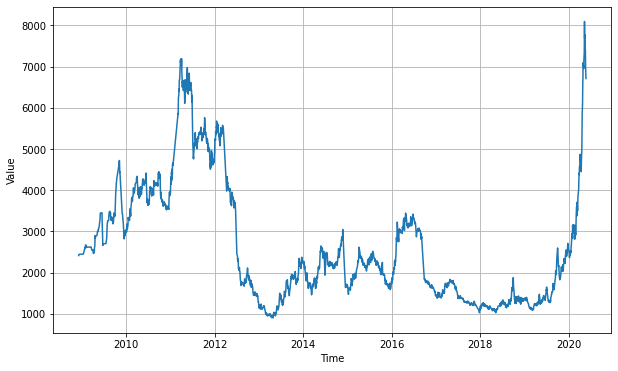

In [148]:
# Normal data

series = np.array(data.Last)
time = np.array(data.index)
plt.figure(figsize=(10, 6))
plot_series(time, series)

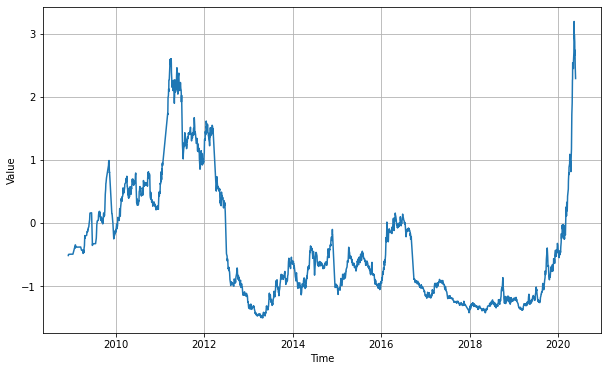

In [149]:
# Standardized Data

series = data['Last'].values.reshape(-1, 1)
scaler = StandardScaler()
scaler.fit(series[:len(series) // 2])
series = scaler.transform(series).flatten()

series = np.array(series)
time = np.array(data.index)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [150]:
split_time = 2000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [151]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [152]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [153]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(2000,)
Epoch 1/100
62/62 [==============================] - 9s 52ms/step - loss: 3.0918 - mae: 3.5440 - lr: 1.0000e-08
Epoch 2/100
62/62 [==============================] - 3s 50ms/step - loss: 2.4925 - mae: 2.9576 - lr: 1.1220e-08
Epoch 3/100
62/62 [==============================] - 3s 52ms/step - loss: 2.0424 - mae: 2.5133 - lr: 1.2589e-08
Epoch 4/100
62/62 [==============================] - 3s 49ms/step - loss: 1.6654 - mae: 2.1373 - lr: 1.4125e-08
Epoch 5/100
62/62 [==============================] - 3s 50ms/step - loss: 1.3472 - mae: 1.8087 - lr: 1.5849e-08
Epoch 6/100
62/62 [==============================] - 3s 48ms/step - loss: 1.0966 - mae: 1.5382 - lr: 1.7783e-08
Epoch 7/100
62/62 [==============================] - 3s 47ms/step - loss: 0.9164 - mae: 1.3427 - lr: 1.9953e-08
Epoch 8/100
62/62 [==============================] - 3s 49ms/step - loss: 0.7852 - mae: 1.2025 - lr: 2.2387e-08
Ep

(1e-08, 0.0001, 0.0, 0.2)

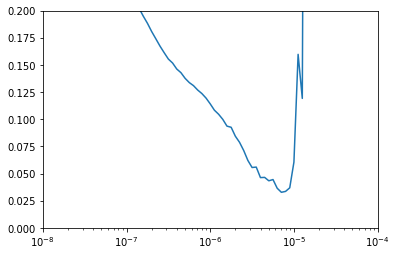

In [154]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 0.2])

In [155]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=256, kernel_size=5,
                         strides=1, padding="causal",
                         activation="relu",
                         input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(learning_rate=7e-6, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=150)

Epoch 1/150
62/62 [==============================] - 9s 58ms/step - loss: 0.6468 - mae: 0.9975
Epoch 2/150
62/62 [==============================] - 4s 58ms/step - loss: 0.1080 - mae: 0.3552
Epoch 3/150
62/62 [==============================] - 4s 56ms/step - loss: 0.0639 - mae: 0.2751
Epoch 4/150
62/62 [==============================] - 4s 57ms/step - loss: 0.0605 - mae: 0.2725
Epoch 5/150
62/62 [==============================] - 4s 55ms/step - loss: 0.0546 - mae: 0.2570
Epoch 6/150
62/62 [==============================] - 4s 55ms/step - loss: 0.0428 - mae: 0.2271
Epoch 7/150
62/62 [==============================] - 4s 56ms/step - loss: 0.0397 - mae: 0.2167
Epoch 8/150
62/62 [==============================] - 4s 56ms/step - loss: 0.0409 - mae: 0.2212
Epoch 9/150
62/62 [==============================] - 4s 56ms/step - loss: 0.0520 - mae: 0.2548
Epoch 10/150
62/62 [==============================] - 4s 56ms/step - loss: 0.0432 - mae: 0.2299
Epoch 11/150
62/62 [=============================

In [156]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

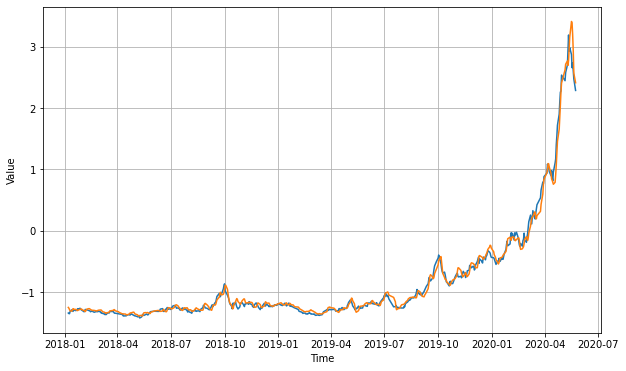

In [157]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [158]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

0.051823124

In [159]:
print(rnn_forecast)

# EXPECTED OUTPUT -- ARRAY OF VALUES IN THE LOW TEENS

[-1.252127   -1.265202   -1.2861756  -1.3067695  -1.3134285  -1.2954766
 -1.2732847  -1.2753558  -1.2853422  -1.2845428  -1.2921023  -1.3024431
 -1.3036121  -1.2956299  -1.2855643  -1.2807591  -1.2764099  -1.2827717
 -1.2934703  -1.3029907  -1.3138798  -1.3201017  -1.3068116  -1.2851954
 -1.2738466  -1.272222   -1.278315   -1.28865    -1.2980826  -1.3027264
 -1.2994812  -1.3025776  -1.3097012  -1.3100322  -1.3028309  -1.3000742
 -1.2970665  -1.2942127  -1.29415    -1.3028339  -1.3160168  -1.3238665
 -1.3318332  -1.3387195  -1.348156   -1.3477138  -1.3382578  -1.3360409
 -1.3247823  -1.3097041  -1.300009   -1.2884401  -1.2896323  -1.3064489
 -1.3236835  -1.3356266  -1.3460647  -1.3529714  -1.3565975  -1.3570634
 -1.3580918  -1.361042   -1.3725111  -1.3763393  -1.3716083  -1.3612137
 -1.3495464  -1.3419412  -1.3416299  -1.3391316  -1.3297341  -1.3306513
 -1.3452529  -1.3593119  -1.3714348  -1.3803688  -1.3910674  -1.3945111
 -1.3844103  -1.3819289  -1.3932363  -1.3889139  -1.365952   -1.